In [58]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, LSTM, Dense, Embedding, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


Importing the data

In [2]:
df=pd.read_csv("Spam_SMS.csv")
df=df.dropna()
df

,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will ü b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


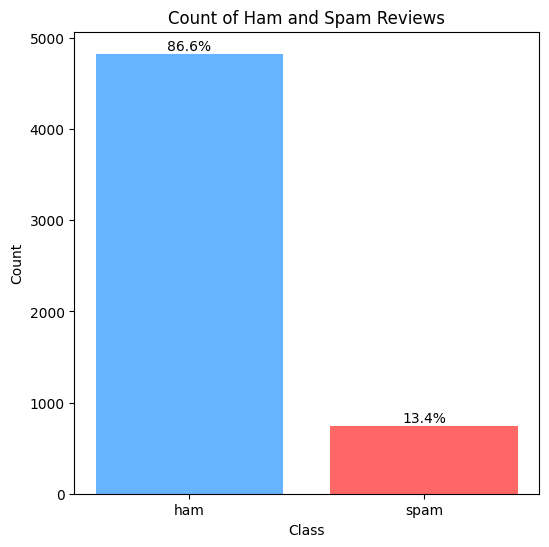

In [4]:
label_counts = df['Class'].value_counts()

# Calculate percentages
total = label_counts.sum()
percentages = (label_counts / total) * 100

# Create a bar plot
plt.figure(figsize=(6, 6))
bars = plt.bar(['ham', 'spam'], label_counts, color=['#66b3ff', '#ff6666'])

# Add percentage labels on top of each bar
for bar, percentage in zip(bars, percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x-coordinate: center of the bar
        bar.get_height(),  # y-coordinate: top of the bar
        f'{percentage:.1f}%',  # label with one decimal place
        ha='center',  # horizontal alignment
        va='bottom'   # vertical alignment
    )

plt.title('Count of Ham and Spam Reviews')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

#### There is only 13.4% of spam messages, but we think that this will be enough to train the NN. Let's divide the data to X and y, and investigate it little bit.

In [19]:
X = df.drop('Class', axis=1)
y = df['Class']

In [28]:
pd.set_option('display.max_colwidth', None)
spam_indexes = y[y.eq('spam')].index
X.iloc[spam_indexes[:5]]

,Message
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
5,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv"
8,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
9,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030
11,"SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info"


Okay so those are the spam messages, they seem pretty interesting, but it is worth noting that there are some words in 'slang' such as 'U R entitled' or shortened words that are supposed to work as abbreviations. Another thing is that the data is probably from Great Britain, because of 'pounds' being mentioned. Those spam messages seem little bit off from what we are used, so that's something to remember when creating some examples of our own to test the model. Last thing is that those are probably SMS messages not email. Let's have a look at ham.

In [32]:
pd.set_option('display.max_colwidth', None)
ham_indexes = y[y.eq('ham')].index
X.iloc[ham_indexes[:5]]

,Message
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,Ok lar... Joking wif u oni...
3,U dun say so early hor... U c already then say...
4,"Nah I don't think he goes to usf, he lives around here though"
6,Even my brother is not like to speak with me. They treat me like aids patent.


Okay, those are also a little bit wicked so let's bear that in mind.

Now let's vectorize that input. We will split on the character, standardize to lower case and set the output_sequence_length to be 910 so that all of the inputs have the same length after vectorizing. You can see that in the output. We have chosen 910 as this was the shape it had without setting this value. So whenever we use this layer it will add padding of 0's if necessary.

In [35]:
text_vec_layer = tf.keras.layers.TextVectorization(split = "character", standardize = "lower",output_sequence_length = 910)
text_vec_layer.adapt(X)

n_tokens = text_vec_layer.vocabulary_size() #0 = padding, 1 = unknown
print("Total chars:", n_tokens)

X_vectorized = text_vec_layer(X)
np.shape(X_vectorized), X_vectorized[0]

Total chars: 85


(TensorShape([5574, 910]),
 <tf.Tensor: shape=(910,), dtype=int64, numpy=
 array([20,  4,  2, 13,  8,  5,  7, 11,  2, 37, 13, 10,  4,  8, 20,  2, 21,
         4,  7,  8,  5, 27,  2, 18, 10,  6, 46, 17, 15, 15,  2,  6, 25,  6,
         7, 11,  6, 23, 11,  3,  2,  4,  8, 11, 17,  2,  7,  8,  2, 23, 13,
        20,  7,  9,  2,  8,  2, 20, 10,  3,  6,  5,  2, 19,  4, 10, 11, 14,
         2, 11,  6,  2,  3,  2, 23, 13, 22, 22,  3,  5, 15, 15, 15,  2, 18,
         7,  8,  3,  2,  5, 12,  3, 10,  3,  2, 20,  4,  5,  2,  6, 16,  4,
        10,  3,  2, 19,  6,  5, 15, 15, 15,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0

Encoding the label: 0 means ham and 1 means spam.

In [36]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y) 
y[:4]

array([0, 0, 1, 0])

Now let's split the train, validation and test data.

In [40]:
X_train_val, X_test, y_train_val, y_test = train_test_split(np.array(X_vectorized), np.array(y), test_size=0.2, random_state=42,shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42,shuffle = True)
np.shape(X_train), np.shape(X_val), np.shape(X_test)

((3567, 910), (892, 910), (1115, 910))

## Model Training    
We are going to compare LSTM with GRU. We will evaluate our models using precision as high precision means fewer false positives, which is equivalent to lower number of legitimate messages wrongly marked as spam. This also means there might be some spam messages that make it through, but we believe it's better than marking legitimate messages as spam.

In [48]:
embedding_vector_features = 30

modelLong = Sequential()
modelLong.add(Embedding(n_tokens, embedding_vector_features, mask_zero=True)) # Input layer with Embedding with mask_zero to get rid off padding tokens
modelLong.add(LSTM(64)) # Long Short Term Memory Recurrent Neural Network 
modelLong.add(Dropout(0.3)) # Some dropout layer to drop neurons to reduce overfitting
modelLong.add(Dense(1, activation='sigmoid')) # Output layer with sigmoid activation to output a number between 0 and 1

modelLong.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Precision()])

#Some callbacks to improve the model.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

In [49]:
history = modelLong.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=10, batch_size=32, 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 231ms/step - loss: 0.4198 - precision_1: 0.4727 - val_loss: 0.1105 - val_precision_1: 0.9456 - learning_rate: 0.0010
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 25s 221ms/step - loss: 0.1267 - precision_1: 0.8868 - val_loss: 0.1468 - val_precision_1: 0.9914 - learning_rate: 0.0010
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 24s 217ms/step - loss: 0.1251 - precision_1: 0.9868 - val_loss: 0.0967 - val_precision_1: 0.9517 - learning_rate: 0.0010
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 24s 211ms/step - loss: 0.0748 - precision_1: 0.9678 - val_loss: 0.0938 - val_precision_1: 0.9718 - learning_rate: 0.0010
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 24s 215ms/step - loss: 0.0983 - precision_1: 0.9726 - val_loss: 0.1073 - val_precision_1: 0.9710 - learning_rate: 0.0010
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 24s 216ms/step - loss: 0.1050 - precision_1: 0.9784 - val_loss: 0.0958 - val_precision_1: 0.9716 - learning_rate: 0.0010
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━

Nice! This model perfroms really well and doesn't overfit. Let's see how the one with GRU will do. I will keep the rest of the NN the same to give them the same starting point.

In [51]:
modelGRU = Sequential()
modelGRU.add(Embedding(n_tokens, embedding_vector_features, mask_zero=True)) # Input layer with Embedding with mask_zero to get rid off padding tokens
modelGRU.add(GRU(64)) # Long Short Term Memory Recurrent Neural Network 
modelGRU.add(Dropout(0.3)) # Some dropout layer to drop neurons to reduce overfitting
modelGRU.add(Dense(1, activation='sigmoid')) # Output layer with sigmoid activation to output a number between 0 and 1

modelGRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Precision()])

#Some callbacks to improve the model.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

In [ ]:
history = modelGRU.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=10, batch_size=32, 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 219ms/step - loss: 0.4432 - precision_2: 0.4366 - val_loss: 0.1739 - val_precision_2: 0.9829 - learning_rate: 0.0010
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 29s 259ms/step - loss: 0.1458 - precision_2: 0.9357 - val_loss: 0.0897 - val_precision_2: 0.9792 - learning_rate: 0.0010
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 245ms/step - loss: 0.0888 - precision_2: 0.9790 - val_loss: 0.0917 - val_precision_2: 0.9787 - learning_rate: 0.0010
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 23s 202ms/step - loss: 0.0925 - precision_2: 0.9825 - val_loss: 0.0921 - val_precision_2: 0.9858 - learning_rate: 0.0010
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 23s 202ms/step - loss: 0.0944 - precision_2: 0.9642 - val_loss: 0.0926 - val_precision_2: 0.9857 - learning_rate: 2.0000e-04
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 23s 201ms/step - loss: 0.1141 - precision_2: 0.9678 - val_loss: 0.0934 - val_precision_2: 0.9856 - learning_rate: 2.0000e-04
Epoch 7/10
112/112 ━━━━━━━

Well, GRU performs slightly better than LSTM on the validation but let's see how both of them do on the test data.

In [57]:
predictionsLong = modelLong.predict(X_test)
predictionsGRU = modelGRU.predict(X_test)
test_loss_long, test_precision_long = modelLong.evaluate(X_test, y_test)
test_loss_GRU, test_precision_GRU = modelGRU.evaluate(X_test, y_test)
print(f'Test precision for LSTM: {round(test_precision_long, 4)} \nTest precision for GRU: {round(test_precision_GRU,4)} ')

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0817 - precision_1: 0.9753
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0740 - precision_2: 0.9874
Test precision for LSTM: 0.9718 
Test precision for GRU: 0.9792 


As expected the difference is small, but GRU wins.

Let's have a look at the confusion matrix for both.

In [66]:
y_pred_gru = modelGRU.predict(X_vectorized)
y_pred_gru[y_pred_gru <= 0.5] = 0
y_pred_gru[y_pred_gru > 0.5] = 1
# Get predictions for the Long model
y_pred_long = modelLong.predict(X_vectorized)
y_pred_long[y_pred_long <= 0.5] = 0
y_pred_long[y_pred_long > 0.5] = 1

# Assuming your target variable is called y
y_true_gru = y
y_true_long = y

175/175 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step


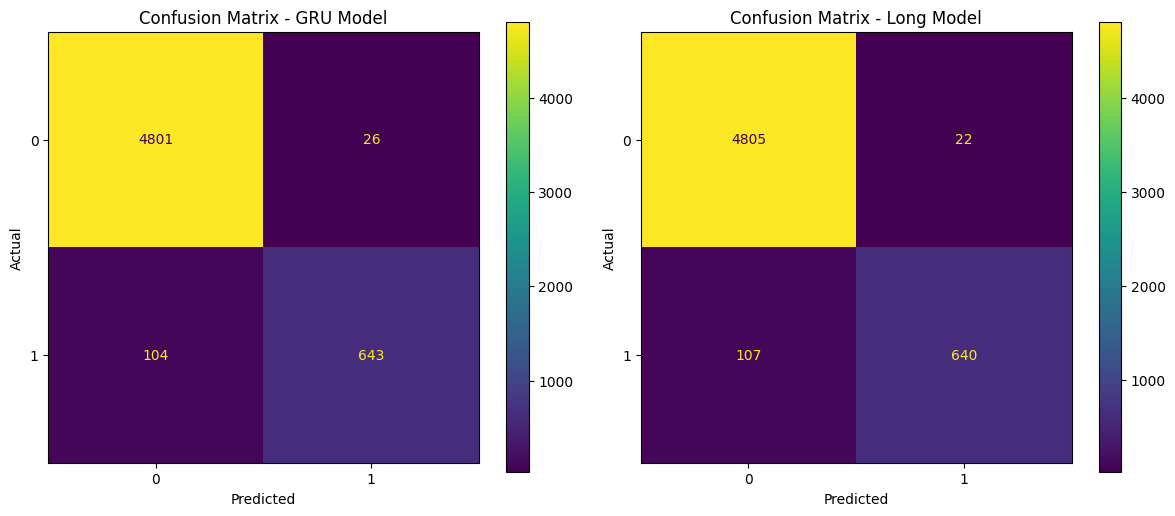

In [67]:
# Confusion matrix for the GRU model
cm_gru = confusion_matrix(y_true_gru, y_pred_gru)
disp_gru = ConfusionMatrixDisplay(confusion_matrix=cm_gru)

# Confusion matrix for the Long model
cm_long = confusion_matrix(y_true_long, y_pred_long)
disp_long = ConfusionMatrixDisplay(confusion_matrix=cm_long)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the GRU model confusion matrix
disp_gru.plot(ax=ax1)
ax1.set_title('Confusion Matrix - GRU Model')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Plot the Long model confusion matrix
disp_long.plot(ax=ax2)
ax2.set_title('Confusion Matrix - Long Model')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

The models were trained on precision so, as we mentioned earlier, they are minimizing the number of false positives - legitimate messages marked as spam. This can clearly be seen on the graph as those numbers are the smallest. LSTM perfroms better with this task with only 22 false positive messages while 26 for GRU. This difference is marginal - it may perform differently on another set.